In [1]:
import os
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from skimage.io import imread
from glob import glob
import cv2

from skimage.color import rgb2gray
from skimage.filters import rank

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [21]:

from pathlib import Path
file_path = os.path.join(os.path.expanduser("~"), "Downloads/")

mask_files = glob(file_path + os.path.join('all_images','*','*_mask*'))
img_files = [file.replace('_mask', '') for file in mask_files]

In [29]:

def label(mask):
    value = np.max(imread(mask))
    return 1 if value > 0 else 0

df = pd.DataFrame({"image": img_files,
                   "mask": mask_files,
                  "label":[label(x) for x in mask_files]})

In [3]:
!pip install -U albumentations

Requirement already up-to-date: albumentations in /opt/anaconda3/lib/python3.8/site-packages (1.1.0)


In [42]:
from skimage.color import rgb2gray
import albumentations as A
from PIL import Image


def Display_img_mask(img_path, mask_path):
    rgb_img = imread(img_path)
    gray_img = rgb2gray(rgb_img)
    mask_img = imread(mask_path)

    fig, axes = plt.subplots(1, 3, figsize=(10, 8))
    ax = axes.ravel()
    ax[0].imshow(rgb_img)
    ax[0].set_title("Original")
    ax[1].imshow(gray_img, cmap=plt.cm.gray)
    ax[1].set_title("Grayscale")
    ax[2].imshow(mask_img)
    ax[2].set_title("Mask")
    fig.tight_layout()

In [44]:
def Display_img_mask2(img, mask):
    gray_img = rgb2gray(img)

    fig, axes = plt.subplots(1, 3, figsize=(10, 8))
    ax = axes.ravel()
    ax[0].imshow(img)
    ax[0].set_title("Original")
    ax[1].imshow(gray_img, cmap=plt.cm.gray)
    ax[1].set_title("Grayscale")
    ax[2].imshow(mask)
    ax[2].set_title("Mask")
    fig.tight_layout()



### Displaying original image and mask

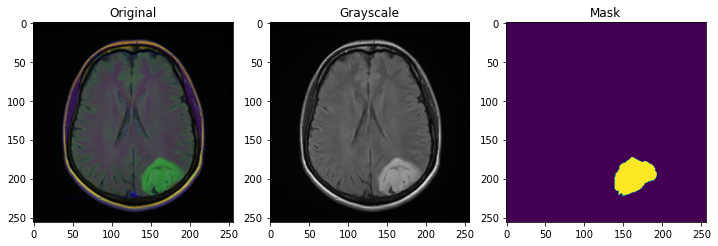

In [46]:
image_example = df[df["label"] == 1].iloc[3, 0]
mask_example = df[df["label"] == 1].iloc[3, 1]
Display_img_mask(image_example,mask_example)

In [49]:
transform = A.Compose([
    A.Flip(p=0.8),
    A.Rotate(limit=90, p=0.8),
    A.RandomContrast(),
    A.RandomBrightnessContrast()
])

/opt/anaconda3/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:1826: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


### Displaying Transformed Image

(256, 256, 3)
(256, 256)


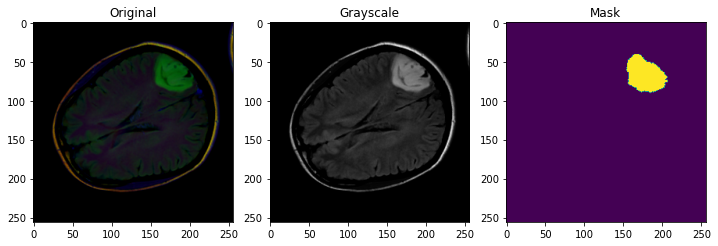

In [47]:
transformed = transform(image=imread(image_example), mask=imread(mask_example))
transformed_image = transformed['image']
transformed_mask = transformed['mask']


print(transformed_image.shape)
print(transformed_mask.shape)
Display_img_mask2(transformed_image, transformed_mask)

## Creating augmented data 

In [48]:
def generate_aug_img(img_path, mask_path):
  img_name = "aug_" + img_path.split("/")[-1]
  mask_name = "aug_" + mask_path.split("/")[-1]

  image = imread(img_path)
  mask = imread(mask_path)
  transformed = transform(image=image, mask=mask)
  transformed_image = transformed['image']
  transformed_mask = transformed['mask']

## **Using Balanced Data (full set of images)**

In [51]:
mask_files = glob(file_path + os.path.join('Balanced_images','*','*_mask*'))
img_files = [file.replace('_mask', '') for file in mask_files]
def label(mask):
    value = np.max(cv2.imread(mask))
    return 1 if value > 0 else 0
df = pd.DataFrame({"image": img_files,
                   "mask": mask_files,
                  "label":[label(x) for x in mask_files]})

In [53]:
df.shape

(5302, 3)

## **Distribution of Labels after data augmentation (by oversampling)**
### **Balanced Labels**

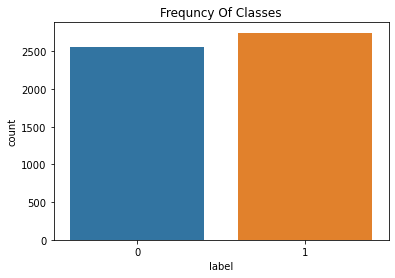

In [54]:
sns.countplot(data=df,x=df['label'])
plt.title('Frequncy Of Classes')
plt.show()

## Feature selection using PCA and Classifications

In [56]:
image_dataset = []

for path in df["image"]:
  gray_im = rgb2gray(cv2.imread(path))
  image_dataset.append(gray_im.reshape(-1))

image_dataset_np = np.array(image_dataset)
print(image_dataset_np.shape)

image_df = pd.DataFrame(image_dataset_np)
print(image_df.shape)

(5302, 65536)
(5302, 65536)


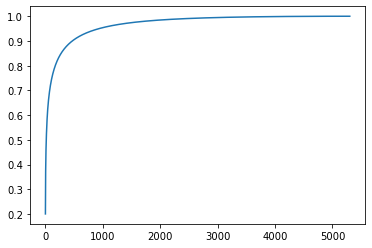

In [57]:
from sklearn  import decomposition 
pca_model = decomposition.PCA() 
pca_model.fit(image_df)
pca_projection = pca_model.transform(image_df)
explianed_var=pca_model.explained_variance_ratio_
plt.plot(np.arange(len(explianed_var)),explianed_var.cumsum())

In [63]:
pca_model2 = decomposition.PCA(n_components=0.9)
pca_model2.fit(image_df)
pca_projection2 = pca_model2.transform(image_df)
print(pca_projection2.shape)




(5302, 470)


## **Creating valiadation set and test set**

In [64]:
X_PCA_features =  pca_projection2

y = df.label

X_train_pca, X_test_pca, y_train, y_test = train_test_split(X_PCA_features, y, test_size=0.1, random_state=42)


X_test_pca, X_val_pca, y_test, y_val = train_test_split(X_test_pca, y_test, test_size = 0.5, random_state = 0)

print(X_train_pca.shape)
print(X_test_pca.shape)

(4771, 470)
(265, 470)


In [119]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import SGDClassifier

names = ["Naive_Bayes","Logistic Regression","Nearest_Neighbors", "Linear_SVM", "Polynomial_SVM", "RBF_SVM", 
         "Gradient_Boosting", "Decision_Tree", "Random_Forest", "QDA",
          "SGD Classifier"]

classifiers = [
    GaussianNB(),
    LogisticRegression(random_state=0, max_iter=1000, C=1.0),
    KNeighborsClassifier(n_neighbors=3),
    SVC(kernel="linear", C=0.025,random_state=0),
    SVC(kernel="poly", random_state=0),
    SVC(kernel="rbf", random_state=0),
    GradientBoostingClassifier(n_estimators=100, learning_rate=1.0),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(n_estimators=300 ,random_state=0),
    QuadraticDiscriminantAnalysis(),
    SGDClassifier(loss="hinge", penalty="l2")]

In [120]:

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score


classification_scores = []
precision = []
recall = []
Fscore = []
classificaation_auc = []


for name, clf in zip(names, classifiers):
    
    clf.fit(X_train_pca, y_train)
    y_pred = clf.predict(X_val_pca)
    score = np.round(clf.score(X_val_pca, y_val),2)
    prec = np.round(precision_score(y_val, y_pred, average='binary'),2)
    rec = np.round(recall_score(y_val, y_pred, average='binary'),2)
    fs= np.round(f1_score(y_val, y_pred, average='binary'),2)
    auc = np.round(roc_auc_score(y_val,y_pred, average = 'macro'),2)
    classification_scores.append(score)
    precision.append(prec)
    recall.append(rec)
    Fscore.append(fs)
    classificaation_auc.append(auc)

In [127]:
df = pd.DataFrame()
df['Classifier_name'] = names
df['Accuracy'] = classification_scores
df['Precision'] = precision
df['Recall'] = recall
df['F_Score'] = Fscore
df['AUC'] = classificaation_auc



In [128]:
df.head()

,Classifier_name,Accuracy,Precision,Recall,F_Score,AUC
0,Naive_Bayes,0.56,0.63,0.43,0.51,0.57
1,Logistic Regression,0.85,0.87,0.85,0.86,0.85
2,Nearest_Neighbors,0.91,0.92,0.92,0.92,0.91
3,Linear_SVM,0.87,0.88,0.87,0.88,0.87
4,Polynomial_SVM,0.84,0.79,0.97,0.87,0.83


In [129]:
df_accuracy = df.sort_values(by="Accuracy", ascending=False)
df_accuracy.reset_index(inplace=True,drop=True)

df_Precision = df.sort_values(by="Precision", ascending=False)
df_Precision.reset_index(inplace=True,drop=True)

df_Recall = df.sort_values(by="Recall", ascending=False)
df_Recall.reset_index(inplace=True,drop=True)

df_Fscore = df.sort_values(by="F_Score", ascending=False)
df_Fscore.reset_index(inplace=True,drop=True)

df_AUC= df.sort_values(by="AUC", ascending=False)
df_AUC.reset_index(inplace=True,drop=True)


In [130]:
df_accuracy .head()

,Classifier_name,Accuracy,Precision,Recall,F_Score,AUC
0,Nearest_Neighbors,0.91,0.92,0.92,0.92,0.91
1,RBF_SVM,0.89,0.90,0.91,0.90,0.89
2,Random_Forest,0.88,0.85,0.94,0.90,0.88
3,Linear_SVM,0.87,0.88,0.87,0.88,0.87
4,Gradient_Boosting,0.86,0.87,0.87,0.87,0.86


Text(0.5, 1.0, 'Accuracy')

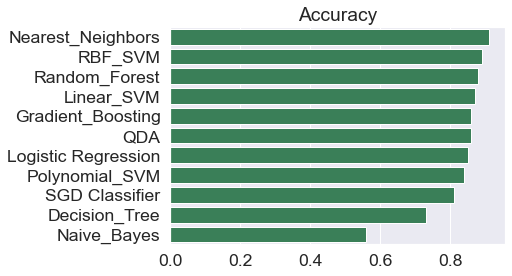

In [131]:
sns.set(font_scale = 1.6)
p = sns.barplot(y="Classifier_name", x="Accuracy", data=df_accuracy, color='seagreen')
p.set_ylabel("")
p.set_xlabel("")
p.set_title('Accuracy')

Text(0.5, 1.0, 'Precision')

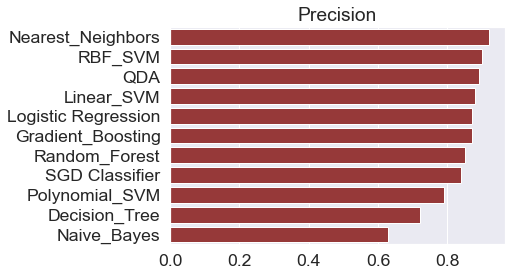

In [132]:
sns.set(font_scale = 1.6)
p = sns.barplot(y="Classifier_name", x="Precision", data=df_Precision, color='brown')
p.set_ylabel("")
p.set_xlabel("")
p.set_title('Precision')


Text(0.5, 1.0, 'Recall')

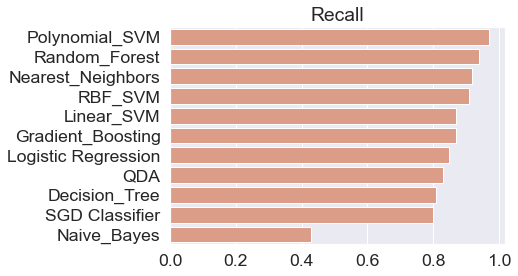

In [133]:
sns.set(font_scale = 1.6)
p = sns.barplot(y="Classifier_name", x="Recall", data=df_Recall, color='darksalmon')
p.set_ylabel("")
p.set_xlabel("")
p.set_title('Recall')


Text(0.5, 1.0, 'AUC')

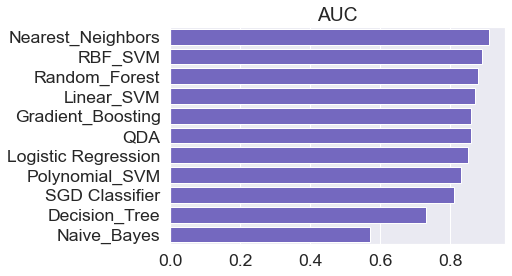

In [134]:
sns.set(font_scale = 1.6)
p = sns.barplot(y="Classifier_name", x="AUC", data=df_AUC, color='slateblue')
p.set_ylabel("")
p.set_xlabel("")
p.set_title('AUC')



## **10-fold Cross Validation**

In [70]:
from sklearn.model_selection import cross_val_score

model_labels = ['Support Vector Machine (RBF)', 'Random Forest Classifier', 'KNN']

KNN_cl = KNeighborsClassifier(n_neighbors=3)
KNN_cl.fit(X_train_pca, y_train)

SVM_rbf = SVC(kernel="rbf", random_state=0)
SVM_rbf.fit(X_train_pca, y_train)

RFC_cl = RandomForestClassifier(n_estimators=300 ,random_state=0)
RFC_cl.fit(X_train_pca, y_train)

for clf_model, lab in zip([SVM_rbf, RFC_cl, KNN_cl], model_labels):
    scores = cross_val_score(estimator=clf_model, X=X_train_pca, y=y_train, cv=10, scoring='roc_auc')
    print("ROC AUC: %0.2f +/- %0.2f [%s]" 
          % (scores.mean(), scores.std(), lab))

ROC AUC: 0.95 +/- 0.01 [Support Vector Machine (RBF)]
ROC AUC: 0.95 +/- 0.01 [Random Forest Classifier]
ROC AUC: 0.95 +/- 0.01 [KNN]
